In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from imbalancer import Imbalancer

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, img_channels, features_g):
        super().__init__()
        self.net = nn.Sequential(
            self._block(input_dim, features_g * 8, 4, 1, 0),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)
    
x = torch.randn(64, 100, 1, 1, device="cuda")
g = Generator(100, 1, 64).to("cuda")
g(x).shape

## Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 2, 1, 0),
        )

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x).view(-1)

## Hyperparameters

In [15]:
batch_size = 64
noise_dim = 100
image_size = 32
img_channels = 1
features_gen = 32
features_disc = 32
epochs = 500
lr = 0.0002
lambda_gp = 10
critic_iterations = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and Imbalance The Dataset (2 approaches)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
images = np.stack([np.array(img) for img, _ in dataset])
labels = [label for _, label in dataset]
minor_class = 1
imb = Imbalancer(images, labels, minor_class=minor_class, keep_ratio=0.2, output_path="../imbalanced_dataset_WGAN_fashion_mnist")
imb.imbalance()
imb.visualize()
imb.save()

data = torch.load("../imbalanced_dataset_WGAN_fashion_mnist/data.pt") # Produced by imbalancer.py
labels = torch.load("../imbalanced_dataset_WGAN_fashion_mnist/labels.pt") # Produced by imbalancer.py
mask = labels == 1
filtered_data = data[mask]
filtered_labels = labels[mask]

#====================================================================================
# Loading locally

# dataset = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
# images = np.stack([np.array(img) for img, _ in dataset])
# labels = [label for _, label in dataset]
# targets = np.array(dataset.targets)
# class_counts = {i: 5000 for i in range(10)}
# class_counts[1] = 500  # Make class 1 smaller

# indices = []
# for cls, count in class_counts.items():
#     cls_indices = np.where(targets == cls)[0]
#     indices.extend(cls_indices[:count])
# imbalanced_subset = Subset(dataset, indices)

# images = []
# labels = []
# for img, label in imbalanced_subset:
#     images.append(img)
#     labels.append(label)
# images = torch.stack(images)
# labels = torch.tensor(labels)

# images = []
# labels = []

# for img, label in imbalanced_subset:
#     images.append(img)
#     labels.append(label)

# images = torch.stack(images)
# labels = torch.tensor(labels)
# mask_0 = labels == 1


# images_1 = images[mask_0]
# labels_1 = labels[mask_0]
# dataset_1 = TensorDataset(images_1, labels_1)
# len(dataset_1)

In [ ]:
dataset = TensorDataset(filtered_data, filtered_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Create Generator & Discriminator

In [19]:
gen = Generator(noise_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.0, 0.9))

## Gradient Penalty

In [20]:
def gradient_penalty(disc, real, fake):
    batch_size, c, h, w = real.shape
    epsilon = torch.rand(batch_size, 1, 1, 1).repeat(1, c, h, w).to(device)
    interpolated = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)
    mixed_scores = disc(interpolated)

    grad = torch.autograd.grad(
        inputs=interpolated, outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad = grad.view(grad.size(0), -1)
    gp = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [21]:
def show_generated_imgs(fake_imgs, real_imgs, epoch, nrow=8):
    # De-normalize from [-1, 1] to [0, 1]
    fake_imgs = fake_imgs[:nrow * nrow] * 0.5 + 0.5
    real_imgs = real_imgs[:nrow * nrow] * 0.5 + 0.5

    # Create grids
    fake_grid = torchvision.utils.make_grid(fake_imgs, nrow=nrow).permute(1, 2, 0).cpu().numpy()
    real_grid = torchvision.utils.make_grid(real_imgs, nrow=nrow).permute(1, 2, 0).cpu().numpy()

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(real_grid)
    axs[0].set_title("Real Images")
    axs[0].axis("off")

    axs[1].imshow(fake_grid)
    axs[1].set_title(f"Generated Images (Epoch {epoch})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


## Training

In [ ]:
for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size_curr = real.size(0)

        for _ in range(critic_iterations):
            noise = torch.randn(batch_size_curr, noise_dim, 1, 1).to(device)
            fake = gen(noise)
            disc_real = disc(real)
            disc_fake = disc(fake.detach())
            gp = gradient_penalty(disc, real, fake)
            lossD = -(torch.mean(disc_real) - torch.mean(disc_fake)) + lambda_gp * gp

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

        # Train Generator
        noise = torch.randn(batch_size_curr, noise_dim, 1, 1).to(device)
        fake = gen(noise)
        output = disc(fake)
        lossG = -torch.mean(output)

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {lossD.item():.4f} | G Loss: {lossG.item():.4f}")

    if epoch % 10 == 0 or epoch == epochs - 1:
        show_generated_imgs(fake, real, epoch)

## Show Samples of The Generated Images

In [ ]:
with torch.no_grad():
    noise = torch.randn(64, noise_dim, 1, 1).to(device)
    fake_images = gen(noise)
    grid = utils.make_grid(fake_images, nrow=8)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Generated Images")
    plt.axis("off")
    plt.show()

## Save The Model

In [ ]:
save_dir = "../saved_models"
os.makedirs(save_dir, exist_ok=True)
torch.save(gen.state_dict(), os.path.join(save_dir, f"WGAN_generator_fashion_mnist_epoch_{epochs}.pth"))
torch.save(disc.state_dict(), os.path.join(save_dir, f"WGAN_discriminator_fashion_mnist_epoch_{epochs}.pth"))

## Balancing The Dataset for Representation

In [ ]:
gen_path = f"../saved_models/WGAN_generator_fashion_mnist_epoch_{epochs}.pth"
imbalanced_data_path = "../imbalanced_dataset_WGAN_fashion_mnist/data.pt"
imbalanced_labels_path = "../imbalanced_dataset_WGAN_fashion_mnist/labels.pt"
output_balanced_dir = "../balanced_dataset_WGAN_fashion_mnist"

minor_class = 1

os.makedirs(output_balanced_dir, exist_ok=True)

data = torch.load(imbalanced_data_path)
labels = torch.load(imbalanced_labels_path)


if data.dim() == 3:
    data = data.unsqueeze(1)



class_counts = torch.bincount(labels)
max_count = class_counts.max().item()
minor_count = class_counts[minor_class].item()
num_to_generate = max_count - minor_count
print(f"Need to generate {num_to_generate} samples for class {minor_class}.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(noise_dim, img_channels, features_gen).to(device)
gen.load_state_dict(torch.load(gen_path, map_location=device))
gen.eval()


generated_images = []

with torch.no_grad():
    for _ in range((num_to_generate + batch_size - 1) // batch_size):
        current_batch_size = min(batch_size, num_to_generate - len(generated_images))
        noise = torch.randn(current_batch_size, noise_dim, 1, 1).to(device)
        fake_imgs = gen(noise).cpu()
        # fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(28, 28), mode='bilinear', align_corners=False)
        # fake_imgs = ((fake_imgs + 1) / 2).clamp(0, 1)
        generated_images.append(fake_imgs)

generated_images = torch.cat(generated_images, dim=0)
generated_labels = torch.full((generated_images.size(0),), minor_class, dtype=torch.long)


balanced_data = torch.cat([data, generated_images], dim=0)
balanced_labels = torch.cat([labels, generated_labels], dim=0)

torch.save(balanced_data, os.path.join(output_balanced_dir, "data.pt"))
torch.save(balanced_labels, os.path.join(output_balanced_dir, "labels.pt"))



print(f"Balanced dataset saved to: {output_balanced_dir}")

## Classes Distribution Before & After

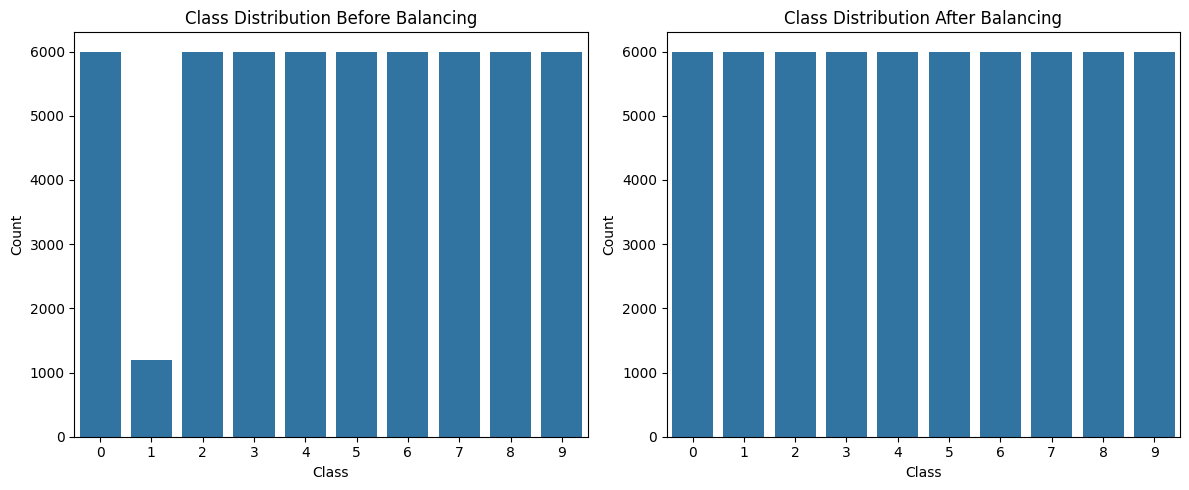

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before balancing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=labels.numpy())
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

# After balancing
plt.subplot(1, 2, 2)
sns.countplot(x=balanced_labels.numpy())
plt.title('Class Distribution After Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()